## Analyze A/B Test Results


This project will assure we have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
rows = df.shape[0]
rows 

294478

c. The number of unique users in the dataset.

In [4]:
users = df['user_id'].nunique()
users

290584

d. The proportion of users converted.

In [5]:
users_converted = df.query("converted == 1")['user_id'].nunique()
users_converted

35173

In [6]:
users_converted / users

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df_miss = df.query("(landing_page == 'new_page' & group != 'treatment') | (landing_page != 'new_page' & group == 'treatment')")
df_miss.shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


>No null value in any row.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  
>df.query("converted == 1").shape[0] / df2.shape[0]

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query("(landing_page == 'old_page' & group == 'control') or (landing_page == 'new_page' & group == 'treatment')")

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

>Row information can be seen in point b above.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df.drop(2893)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df.query("converted == 1").shape[0] / df2.shape[0]

0.11965959990084116

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query("group == 'control' & converted == 1").shape[0] / df2.query("group == 'control'").shape[0]

0.12039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query("group == 'treatment' & converted == 1").shape[0] / df2.query("group == 'treatment'").shape[0]

0.11892038703106433

d. What is the probability that an individual received the new page?

In [17]:
df2.query("landing_page == 'new_page'").shape[0] / df2.shape[0]

0.49999830207452534

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

> Yes, I think some new treatment page can leads to more conversastion.  
Because the probability of late treatment, which is 0.119, is so much close to the control group, which is 0.120.
Maybe some improvement can booost the convert probability.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
> **$H_{0}$** : **$p_{old}$** >= **$p_{new}$**  
> **$H_{1}$** : **$p_{old}$** <  **$p_{new}$** 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [18]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11965959990084116

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.converted.mean()
p_old

0.11965959990084116

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

147275

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query('group == "control"').shape[0]
n_old

147202

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, p=p_new, size=n_new)
new_page_converted = new_page_converted.mean()
new_page_converted

0.11938889831947037

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p=p_old, size=n_old)
old_page_converted = old_page_converted.mean()
old_page_converted

0.11785165962418989

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted - old_page_converted

0.0015372386952804823

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.binomial(1, p=p_new, size=n_new)
    old_page_converted = np.random.binomial(1, p=p_old, size=n_old)
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

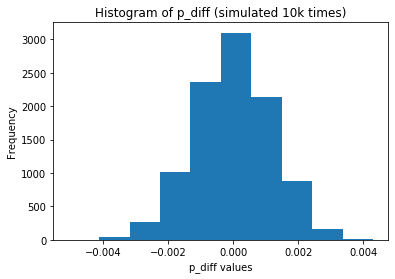

In [27]:
plt.hist(p_diffs)
plt.xlabel('p_diff values')
plt.ylabel('Frequency')
plt.title('Histogram of p_diff (simulated 10k times)');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# get the average classroom time for control group
control_mean = df.query('group == "control"').converted.mean()

# get the average classroom time for experiment group
experiment_mean = df.query('group == "treatment"').converted.mean()

# display average classroom time for each group
control_mean, experiment_mean

(0.12039917935897611, 0.11891957956489856)

In [29]:
# compute observed difference in classroom time
obs_diff = experiment_mean - control_mean

# display observed difference
obs_diff

-0.0014795997940775518

In [30]:
# convert to numpy array
p_diffs = np.array(p_diffs)

# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

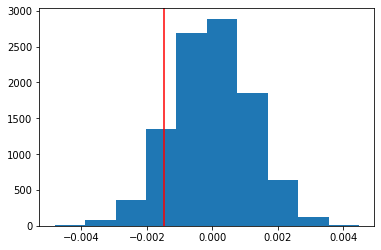

In [31]:
# plot null distribution
plt.hist(null_vals)

# plot line for observed statistic
plt.axvline(obs_diff, c='red');

In [32]:
# compute p value
(null_vals > obs_diff).mean()

0.8896

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
>As we calculated above, our p-value is not small. This value determines the statistical significance of the observations.  
Since we got big p-value, we can't reject our null value. Therefore, recent new page implementations are not needed.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [34]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [35]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3676550601457342, 0.9142899634897912)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [36]:
from scipy.stats import norm

# How significancy our z-score is
print("Significancy: ", norm.cdf(z_score))

# How our critical value at 95% confidence is for one-sided test
print("Critical value: ", norm.ppf(1-(0.05)))

Significancy:  0.9142899634897912
Critical value:  1.6448536269514722


**Put your answer here.**
>* Since critical value is bigger than z-score, we still can't reject the null hypothesis.
>* The p-value from `sm.stats.proportions_ztest` function is so big, same as the result from point **j.**.
>* Then we agree with the findings in parts **j.** and **k.** Still can't reject the null hyphotesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**
>Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
# Make intercept column with value 1
df2['intercept'] = 1

# Make ab_page column using map() method function
mapping = {'treatment':1, 'control':0}
df2['ab_page'] = df2['group'].map(mapping)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366244
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294477
Model:                          Logit   Df Residuals:                   294475
Method:                           MLE   Df Model:                            1
Date:                Thu, 09 Jul 2020   Pseudo R-squ.:               7.085e-06
Time:                        13:22:20   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9887      0.008   -248.297      0.000      -2.004      -1.973
ab_page       -0.0140      0.011     -1.236      0.216      -0.036       0.008
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**  
p-value associated with ab_page is 0.216. It's value is differ from the value in **Part II**, because in logistic regression we do two-sided test, and in **Part II** we did one-sided test.

> **$H_{0}$** : **$p_{old}$** =  **$p_{new}$**  
**$H_{1}$** : **$p_{old}$** !=  **$p_{new}$** 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
>Yes, we need to consider adding other factors to our regression model. Maybe this addition can lead to more precise  model. Since from the result, ab_page variable is not statistically significant enough to reject our null hypothesis.   

>The disadvantage that may be arise is depends on what variable we want to add later. Like in our lesson before (multicollinearity case). The bedroom is have high correlation to bathroom, this can be seen from the sns.pairplot() function and VIF factor examination. So, it's very depends on what we want to add, then we examine it thoroughly and tune it.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
# Change user_id to index
df2 = df2.set_index('user_id')
countries = countries.set_index('user_id')

# Join two data frame
df3 = df2.join(countries, how='inner')

In [42]:
# Explore country unique value
df3.country.unique()

array(['US', 'UK', 'CA'], dtype=object)

In [43]:
# Make dummy column for country
df3[['US', 'UK', 'CA']] = pd.get_dummies(df3['country'])

df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
user_id,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,US,0,0,1
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,US,0,0,1
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,US,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,US,0,0,1
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,US,0,0,1


In [44]:
logit = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366239
         Iterations 6


In [45]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294477
Model:                          Logit   Df Residuals:                   294473
Method:                           MLE   Df Model:                            3
Date:                Thu, 09 Jul 2020   Pseudo R-squ.:               1.910e-05
Time:                        13:22:25   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2489
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0249      0.026    -76.729      0.000      -2.077      -1.973
ab_page       -0.0140      0.011     -1.233      0.218      -0.036       0.008
CA             0.0357      0.027      1.339      0.181      -0.017       0.088
UK             0.0449      0.028      1.596      0.110      -0.010       0.100
==============================================================================
"""

>In short, this model is the same as the previous model result.  
>From our summary result above, none of variables have statistically significance to reject our null value. On the other word, there is no need to implement the new_page. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
# We add interaction between our country and ab_page and add it into new 
# column each

# UK * ab_page
df3['UK_ab_page'] = df3['UK']*df3['ab_page']

# CA * ab_page
df3['CA_ab_page'] = df3['CA']*df3['ab_page']

# Calling function and fitting same as before
logit = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366236
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294477
Model:                          Logit   Df Residuals:                   294471
Method:                           MLE   Df Model:                            5
Date:                Thu, 09 Jul 2020   Pseudo R-squ.:               2.832e-05
Time:                        13:22:28   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2957
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9992      0.036    -55.372      0.000      -2.070      -1.928
ab_page       -0.0658      0.052     -1.277      0.202      -0.167       0.035
UK             0.0086      0.040      0.219      0.827      -0.069       0.086
CA             0.0120      0.037      0.322      0.747      -0.061       0.085
UK_ab_page     0.0732      0.056      1.300      0.194      -0.037       0.184
CA_ab_page     0.0478      0.053      0.896      0.370      -0.057       0.152
==============================================================================
"""

>Still, adding a interaction between country and ab_page column didn't change our 

> Pourtant, l'ajout d'une interaction entre le pays et la colonne ab_page n'a pas changé notre

>Still, adding an interaction between country and ab_page can't change our decision. All of the predictor from third logistic regression is lack of significancy to reject our null hypothesis.  
>So far we better use the page, instead of launching the new page.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

### Conclusion
> We have fitted three logistic regression and just saw each result. All of them is not good enough to reject our null hypothesis. All of the variable p-value is beyond 0.05.   
> Then, based on our easy and hard way to implement A/B testing for this lab, we decide that. The implementation of the new page is not needed for now.   
> The limitations that we have is, we lack of important variable to our model, maybe addition like duration or day can lead to more precise model.


### Resources
* Udacity Data Analyst Nanodegree Program, Lesson 3. Practical Statistics
* [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/index.html)
* [statsmodels documentation](https://www.statsmodels.org/stable/index.html)

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0